# Inference and Validation

We can use the trained network to make a prediction which is typically called **inference**. However, neural network have a tendency to perform well on training data and not generalize on unseen data. This problem is known as **overfitting**. To test the neural network for overfiting, we measure the performance on data not in the training set called the **validation** set

In [5]:
import torch
from torchvision import datasets, transforms


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [6]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x))
    
        return x
        
        


In [13]:
model = Classifier()

images, label = next(iter(trainloader))

ps = torch.exp(model(images))

print(ps[0:3])

#TopK returns the index of largest k element. When we pass 1, it will return one index which is the highest element of Tensor.
top_probabilities, top_class = ps.topk(1, dim = 1)

print(top_class[0:3])
print(top_probabilities[0:3])

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[0.1108, 0.0989, 0.0935, 0.1056, 0.1062, 0.1046, 0.1082, 0.0875, 0.0965,
         0.0882],
        [0.1068, 0.1030, 0.0907, 0.1091, 0.1082, 0.1066, 0.1062, 0.0873, 0.0947,
         0.0873],
        [0.1135, 0.1025, 0.0925, 0.1030, 0.1062, 0.1027, 0.1089, 0.0864, 0.0974,
         0.0869]], grad_fn=<SliceBackward>)
tensor([[0],
        [3],
        [0]])
tensor([[0.1108],
        [0.1091],
        [0.1135]], grad_fn=<SliceBackward>)


Now we check if the predicted classes match the labels. This is as simple as equating the top_class and labels but we need to be careful with shapes. Top class is 2D tensor with (64, 1) while labels is 1D with shape (64). TO get the equatiy work, we need them to have same shape which can be done with the following trick.

**equals = top_class == label.view(*top_class.shape)**


In [14]:
label.shape

torch.Size([64])

In [15]:
equals = top_class == label.view(top_class.shape)

In [16]:
equals.type(torch.FloatTensor)

tensor([[0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

Now, we can use the above tensor to calculate accuracy just by taking the mean. 

In [17]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print('Accuracy is', accuracy.item()*100, '%')

Accuracy is 10.9375 %


In [31]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)
epoch = 100
steps = 0

train_losses, test_losses = [], []

for e in range(epoch):
    running_loss = 0    
    for images, label in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                
                top_p, top_class = ps.topk(1, dim= 1)
                
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        train_losses.append(running_loss / len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}..".format(e+1, epoch),
              "Training loss: {:.3f}... ".format(running_loss / len(trainloader)),
               "Test Loss: {:.3f}.. ".format(test_loss, len(testloader)),
               "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
    

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/100.. Training loss: 0.513...  Test Loss: 74.401..  Test Accuracy: 0.829
Epoch: 2/100.. Training loss: 0.389...  Test Loss: 61.700..  Test Accuracy: 0.855
Epoch: 3/100.. Training loss: 0.353...  Test Loss: 63.337..  Test Accuracy: 0.854
Epoch: 4/100.. Training loss: 0.329...  Test Loss: 60.231..  Test Accuracy: 0.867
Epoch: 5/100.. Training loss: 0.309...  Test Loss: 59.941..  Test Accuracy: 0.864
Epoch: 6/100.. Training loss: 0.303...  Test Loss: 61.442..  Test Accuracy: 0.865
Epoch: 7/100.. Training loss: 0.291...  Test Loss: 61.195..  Test Accuracy: 0.866
Epoch: 8/100.. Training loss: 0.282...  Test Loss: 56.947..  Test Accuracy: 0.878
Epoch: 9/100.. Training loss: 0.272...  Test Loss: 59.074..  Test Accuracy: 0.872
Epoch: 10/100.. Training loss: 0.264...  Test Loss: 57.733..  Test Accuracy: 0.876
Epoch: 11/100.. Training loss: 0.257...  Test Loss: 57.605..  Test Accuracy: 0.876
Epoch: 12/100.. Training loss: 0.249...  Test Loss: 56.862..  Test Accuracy: 0.877
Epoch: 13/100

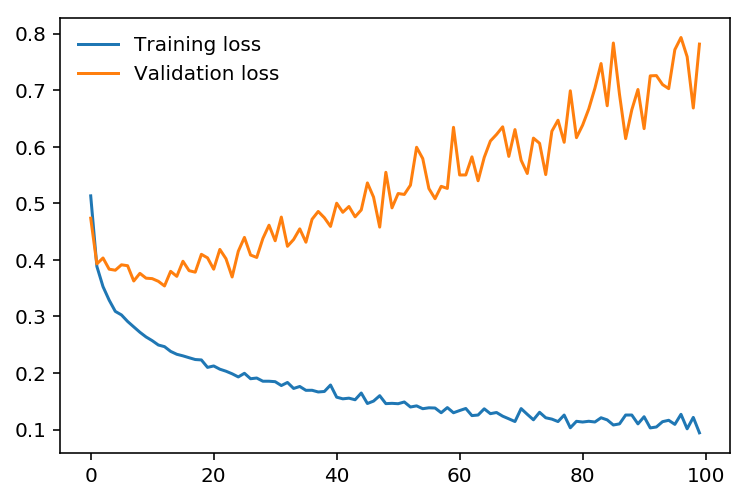

In [32]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon=False)

From the above figure, we can see that Network learns training data and can't generalize on test data. One solution is to use dropout which means randomly dropping out input units between the layers. This forcec network to share information between the weights

# Dropout

In [20]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p = 0.2)
        
    def forward(self, x):
        #FLattened input tensor 
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        #output so no dropout
        x = F.log_softmax(self.fc4(x), dim = 1)
        
        return x

```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

In [21]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)
epoch = 100
steps = 0

train_losses, test_losses = [], []

for e in range(epoch):
    running_loss = 0    
    for images, label in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            for images, labels in testloader:
                
                # set model to evaluation mode
                model.eval()
                
                log_ps = model(images)
                
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                
                top_p, top_class = ps.topk(1, dim= 1)
                
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        #Setting model to train mode
        model.train()
        
        train_losses.append(running_loss / len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}..".format(e+1, epoch),
              "Training loss: {:.3f}... ".format(running_loss / len(trainloader)),
               "Test Loss: {:.3f}.. ".format(test_loss, len(testloader)),
               "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
    

Epoch: 1/100.. Training loss: 0.608...  Test Loss: 78.642..  Test Accuracy: 0.824
Epoch: 2/100.. Training loss: 0.483...  Test Loss: 73.324..  Test Accuracy: 0.837
Epoch: 3/100.. Training loss: 0.461...  Test Loss: 65.590..  Test Accuracy: 0.848
Epoch: 4/100.. Training loss: 0.437...  Test Loss: 61.932..  Test Accuracy: 0.857
Epoch: 5/100.. Training loss: 0.413...  Test Loss: 63.620..  Test Accuracy: 0.855
Epoch: 6/100.. Training loss: 0.412...  Test Loss: 62.938..  Test Accuracy: 0.854
Epoch: 7/100.. Training loss: 0.407...  Test Loss: 60.348..  Test Accuracy: 0.864
Epoch: 8/100.. Training loss: 0.396...  Test Loss: 63.686..  Test Accuracy: 0.860
Epoch: 9/100.. Training loss: 0.394...  Test Loss: 58.871..  Test Accuracy: 0.868
Epoch: 10/100.. Training loss: 0.387...  Test Loss: 62.555..  Test Accuracy: 0.863
Epoch: 11/100.. Training loss: 0.388...  Test Loss: 62.079..  Test Accuracy: 0.858
Epoch: 12/100.. Training loss: 0.380...  Test Loss: 60.420..  Test Accuracy: 0.869
Epoch: 13/100

Epoch: 99/100.. Training loss: 0.284...  Test Loss: 64.704..  Test Accuracy: 0.879
Epoch: 100/100.. Training loss: 0.292...  Test Loss: 65.778..  Test Accuracy: 0.881


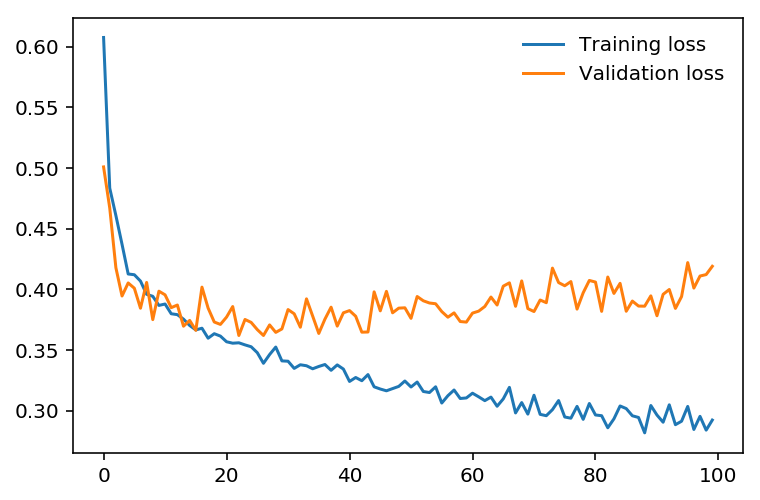

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# Saving and Loading Model

In [23]:
print('Our model: \n\n', model, '\n')

Our model: 

 Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



In [29]:
print('The state dick keys: \n\n', model.state_dict().keys())

The state dick keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [40]:
torch.save(model.state_dict(), 'droped_out_model.pth')

In [41]:
state_dict = torch.load('droped_out_model.pth')
print(state_dict.keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


To load the state dict in to the network, we need following code

In [42]:
model.load_state_dict(state_dict)
model.eval()

NameError: name 'loaded_model' is not defined

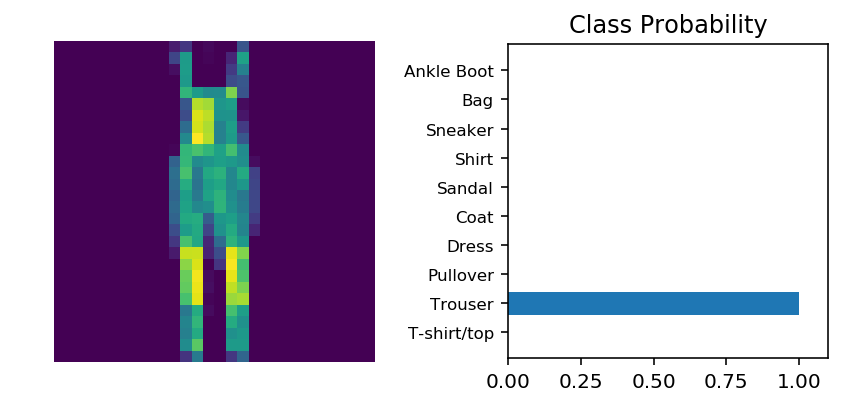

In [39]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')